In [1]:
from pyforest import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
import keras
keras.__version__
from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
df = pd.read_csv('dataset_negative_a4.csv')
df = df.drop('Unnamed: 0',axis=1)


In [4]:
useless_cols = ['0_0', '0_1','0_8','0_9', '1_0','1_9','8_0','8_9' ,
 '9_0','9_1','9_8', '9_9','a4','filename','process_name']
cols = list(set(df.columns)-set(useless_cols))
features = ['height','tmp_integral','hot_spot_nums','meantmp','maxtmp']#5个
target_cols = list(set(cols)-set(features))
data = df[cols]
data = data.sort_index(axis=1)
data.head()

,0_2,0_3,0_4,0_5,0_6,0_7,1_1,1_2,1_3,1_4,...,9_3,9_4,9_5,9_6,9_7,height,hot_spot_nums,maxtmp,meantmp,tmp_integral
0,14.931554,34.346891,39.835429,40.191638,33.632722,14.421854,16.715736,38.287265,29.690878,27.131157,...,24.667206,31.297984,36.121219,37.373089,15.373827,160.2,5,61.5,32.0,0
1,8.913243,22.720394,29.325646,34.828198,35.670058,16.989400,15.846219,30.984550,31.000000,30.943469,...,34.068593,40.652358,40.842240,35.626369,15.803187,159.1,5,54.2,31.0,0
2,8.527942,21.499579,28.010541,28.115348,22.117600,9.087723,15.129300,29.589053,29.600000,29.600000,...,35.804194,43.720837,46.073485,38.088251,18.834450,144.2,5,59.6,29.6,0
3,8.116887,20.494383,26.465959,26.627716,20.854221,8.482711,15.285512,27.964890,28.000000,28.000000,...,37.093359,41.939217,40.793141,34.147951,17.453147,140.0,5,57.5,28.0,0
4,16.101558,35.915544,43.208864,26.690511,20.887920,8.576192,27.343416,38.234215,29.952399,26.733929,...,39.327957,44.924275,41.481671,31.163036,14.635703,152.4,5,62.7,27.9,0


In [5]:
data.shape

(23635, 93)

In [6]:
float_data  = data.values[:,:-4] 

In [7]:
float_data.shape

(23635, 89)

In [8]:
# #标准化
mean = float_data.mean(axis=0)
float_data -= mean
std = float_data.std(axis=0)
index = (std == 0.0)
std[index] = 1
float_data /= std

In [38]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                          data.shape[-1]))
        targets = np.zeros((len(rows)))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][40]
#             index_11 = (targets[j] >=30)
#             index_22 = (targets[j] <30)
#             targets[j][index_11] = 1
#             targets[j][index_22] = 0
        yield samples, targets

In [39]:
lookback = 120
step = 1
delay = 2
batch_size = 16

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=18000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=18000,
                    max_index=None,
                  shuffle=False,
                    step=step,
                    batch_size=batch_size)
# test_gen = generator(float_data,
#                      lookback=lookback,
#                      delay=delay,
#                        shuffle=False,

#                      min_index=22008,
#                      max_index=None,
#                      step=step,
#                      batch_size=batch_size)

train_steps = 18000//batch_size
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (len(float_data) - 18000 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
# test_steps = (len(float_data) - 22008 - lookback) // batch_size

In [40]:
val_steps

344

In [41]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, :-1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

ValueError: operands could not be broadcast together with shapes (16,88) (16,) 

In [42]:
np.mean(std[:-5]*0.2658410601766722)


0.44981167938484695

In [68]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,SGD,Adagrad

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=Adagrad(lr=0.01, epsilon=None, decay=0.0), loss='mse')
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=3,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/3


ValueError: setting an array element with a sequence.

In [46]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam,Adagrad
from keras.layers import LSTM
from keras.layers import Dense
from keras import metrics

model = Sequential()
# model.add(LSTM(32, input_shape=(None,float_data.shape[-1])))
# model.add(Dense(1))

# model.add(layers.GRU(64,return_sequences=True,
# #                      recurrent_dropout = 0.5,
#                      input_shape=(None, float_data.shape[-1])))
# model.add(layers.GRU(32,activation='relu',
# #                      recurrent_dropout = 0.5,
#                     dropout=0.1))
model.add(layers.GRU(128,return_sequences=True,input_shape=(None, float_data.shape[-1])))
# model.add(layers.GRU(64,activation='relu',return_sequences=True))
model.add(layers.GRU(32,return_sequences=True,dropout=0.2))
model.add(layers.GRU(16,dropout=0.2))

# # , activation='relu'
model.add(layers.Dense(1))
# 、, metrics=[metrics.mae]
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.add(layers.Dense(88,activation='sigmoid'))
# model.compile(optimizer='rmsprop',# 还可以通过optimizer = optimizers.RMSprop(lr=0.001)来为优化器指定参数
#                   loss='binary_crossentropy', # 等价于loss = losses.binary_crossentropy
#                   metrics=['accuracy']) # 等价于metrics = [metircs.binary_accuracy]
model.compile(optimizer=Adagrad(lr=0.01, epsilon=None, decay=0.0), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=train_steps,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
1125/1125 [==============================] - 392s 348ms/step - loss: 0.2577 - val_loss: 0.2752
Epoch 2/10
1125/1125 [==============================] - 393s 349ms/step - loss: 0.2322 - val_loss: 0.2633
Epoch 3/10
1125/1125 [==============================] - 359s 319ms/step - loss: 0.2253 - val_loss: 0.2489
Epoch 4/10
1125/1125 [==============================] - 366s 326ms/step - loss: 0.2215 - val_loss: 0.2514
Epoch 5/10
 203/1125 [====>.........................] - ETA: 5:42 - loss: 0.2413

In [ ]:
train_steps

In [21]:
def evaluate_naive_method1():
    batch_maes = []
    pred = []
    target = []
    for step in range(val_steps):
        samples, targets = next(train_gen)
#         print(targets.shape)
#         break
        preds = model.predict(samples)
        pred.append(preds)
        target.append(targets)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    return pred,target
pred,target = evaluate_naive_method1()
# evaluate_naive_method1()

0.2742423490205359


In [22]:
pred[0]

array([[-0.49567986, -0.5179526 , -0.53391373, ..., -0.5681763 ,
        -0.53380096, -0.5194895 ],
       [-0.5343505 , -0.56199414, -0.5909862 , ..., -0.62041634,
        -0.5782133 , -0.5513606 ],
       [-0.5231558 , -0.55271894, -0.5763505 , ..., -0.61133474,
        -0.56742585, -0.5431173 ],
       ...,
       [-0.4396833 , -0.43172264, -0.4317469 , ..., -0.46333033,
        -0.44845077, -0.4518953 ],
       [-0.46575376, -0.46791828, -0.47535208, ..., -0.49683237,
        -0.4865076 , -0.4724628 ],
       [-0.4440349 , -0.4440006 , -0.44524303, ..., -0.46934515,
        -0.45790944, -0.45124477]], dtype=float32)

In [23]:
target[0]

array([[-0.6220743 , -0.68814509, -0.67809906, ..., -0.52246308,
        -0.49186529, -0.41503105],
       [-0.40569635, -0.45535115, -0.48620802, ..., -0.66202138,
        -0.63483422, -0.38008249],
       [-0.56413816, -0.62843838, -0.64380052, ...,  0.27026421,
         0.475425  ,  0.35411529],
       ...,
       [-0.06676795, -0.06998961,  0.26262901, ..., -0.46500878,
        -0.43845052, -0.47179672],
       [-0.51188484, -0.52697616, -0.49133429, ..., -0.47731942,
        -0.40452779, -0.39065126],
       [-0.33211394,  0.17281006, -0.50502119, ..., -0.46930347,
        -0.43092875, -0.40070638]])

In [30]:
ans = []
ans_1 = []
for i in pred[1]:
    ans.append(i[0])
for i in target[1]:
    ans_1.append(i[0])
print(len(ans),len(ans_1))

16 16


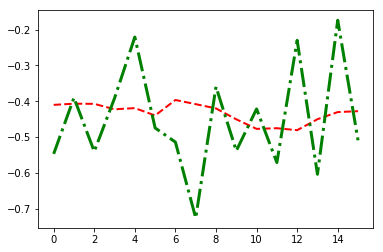

In [31]:
plt.plot(range(len(ans)),ans,color='red',linewidth=2.0,linestyle='--')
plt.plot(range(len(ans_1)),ans_1,color='g',linewidth=3.0,linestyle='-.')
# plt.scatter(range(len(ans)),ans,"r",label="pred")
# plt.scatter(range(len(ans_1)),ans_1,"g",label="target")

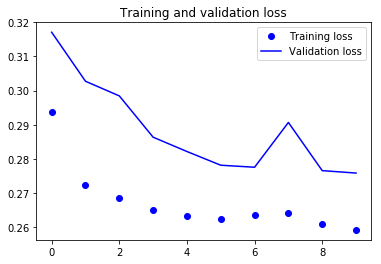

In [29]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
0.27*std[0]

0.33233709379193604